# **Retrieval-augmented generation**

RAG is a framework that combines two important components:
- **Retrieval**: Utilizes algorithms/systems to search a knowledge base.
- **Generation**: LLMs' ability to predict probable next words based on context.

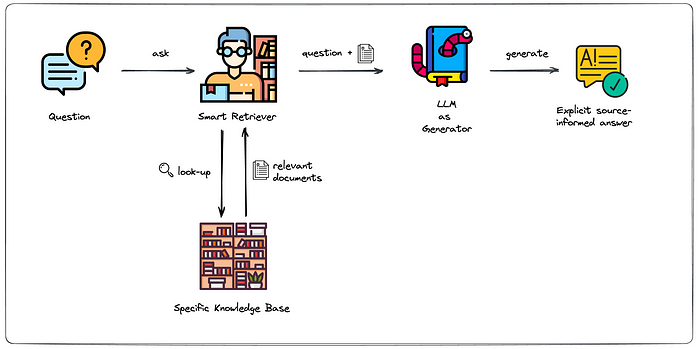


## What is the Use-Case ?
One of the most powerful applications enabled by LLMs is sophisticated question-answering (Q&A) chatbots. These are applications that can answer questions about specific source information.

Lets build an chatbot which can do a Question/Answer on Blogs !

Will be using blog from our thoughtworks website: [Blog on technology radar](https://www.thoughtworks.com/en-in/insights/blog/technology-strategy/five-ways-a-technology-radar-can-help-your-enterprise-navigate-tech)



In [ ]:
## Install library's needed !

!pip3 install langchain-text-splitters chromadb sentence-transformers google-generativeai

## Building the knowledge base [ Vector database ]

### 1. Defining the Data
Get the text data which the chatbot should be using as the knowledge base.
Eg: Website, PDF, Docs, CSV etc.

[Checkout for more document loaders](https://python.langchain.com/docs/modules/data_connection/document_loaders/)

In [ ]:
# Lets get the data needed for the knowledge base

# The blog.txt contains info from the blog:
with open("/content/blog.txt") as f:
    blog_content = f.read()


### 2. Chunking
Chunking involves breaking down texts into smaller, manageable pieces called "chunks." Each chunk becomes a unit of information that is vectorized and stored in a database.
- Chunk size is the maximum number of characters that a chunk can contain.
- Chunk overlap is the number of characters that should overlap between two adjacent chunks.

[Checkout chunking techniques](https://www.rungalileo.io/blog/mastering-rag-advanced-chunking-techniques-for-llm-applications)

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100,
)
chunked_texts = text_splitter.split_text(blog_content)
print(len(chunked_texts))

24


### 3. Embedding
Embedding is a means of representing objects like text, images and audio as points in a continuous vector space.

[More on embedding](https://www.ibm.com/topics/embedding)

In [ ]:
from sentence_transformers import SentenceTransformer

# create the open-source embedding function
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(chunked_texts)

print(f"Text: {chunked_texts[0]} | Embedding: {embeddings[0]}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Text: Title: Five ways a technology radar can help your enterprise navigate tech
Blogs
Technology strategyBlog
By Scott Shaw
Published: March 06, 2024 | Embedding: [ 1.00090504e-02 -3.90897766e-02 -2.84681134e-02 -5.72196394e-02
  6.12103939e-02 -1.79660693e-02  1.05254754e-01  2.69252583e-02
 -8.45685601e-02 -1.15626259e-02 -5.35219871e-02  1.07300885e-01
  5.75535558e-02  2.30071191e-02  4.34287935e-02 -2.48843450e-02
 -3.23252454e-02 -9.62183326e-02  2.32952051e-02 -4.76998655e-04
  2.38315258e-02  1.57180112e-02  4.46777977e-02  5.44528943e-03
 -6.91067874e-02  2.26908028e-02 -9.96975787e-03 -1.00960091e-01
 -7.25265816e-02 -1.62583198e-02 -2.91389544e-02  6.62403032e-02
 -6.07541837e-02  7.42059946e-02 -4.35844995e-02 -1.04041323e-01
  1.86670553e-02  8.52982849e-02  7.58819431e-02 -3.50894220e-02
 -7.54292181e-04 -7.56325126e-02 -2.84730941e-02  4.69938200e-03
  1.38883898e-02 -1.94184389e-02 -4.84037884e-02 -6.66629076e-02
 -1.66580081e-02 -7.65572339e-02 -1.26507372e-01 -4.9191

### 4. Create Vector Database
A vector database indexes and stores vector embeddings for fast retrieval and similarity search, with capabilities like CRUD operations, metadata filtering, horizontal scaling, and serverless.

[Comparison of vector database](https://www.datacamp.com/blog/the-top-5-vector-databases)

In [ ]:
import chromadb

# creating an chroma vector db instance and collection
chroma_client = chromadb.Client()
collection = chroma_client.get_or_create_collection(name="blog")

# store the embeddings created in the collection
collection.add(
    embeddings=embeddings,
    documents=chunked_texts,
    ids=[str(i+1) for i in range(len(chunked_texts))],
)

### 5. Vector Search
Vector search is a method of information retrieval where documents and queries are represented as vectors instead of plain text.

[Vector Similarity beyond Search](https://qdrant.tech/articles/vector-similarity-beyond-search/#vector-similarity-beyond-search)

In [ ]:
# Function to search the database
def vector_search(query, top_k=4):

  # create embedding of the query
  embeddings = embedding_model.encode([query])

  # similarity search using the embedding, give top n results which are close to the query embeddings
  result = collection.query(
      query_embeddings=embeddings,
      n_results=top_k,
  )
  return result['documents']

search_result = vector_search("What is tech radar ?")
print(search_result[0])

['What is the Technology Radar?\nBack in 2010, a group of Thoughtworkers developed the Technology Radar to track technology and keep our CTO informed of what was going on inside Thoughtworks.', 'A radar also allows teams to be more deliberate about tech decisions and how technologies are evaluated and assessed. Essentially, it provides a way to simplify the complexities of your tech portfolio and make strategic choices around the acute challenges facing your industry.', 'The process of building your technology radar brings together the decision makers and the users of technology and provides an open forum to voice concerns, ideas and thoughts. For us (and our clients) it often leads to powerful conversations.', 'Title: Five ways a technology radar can help your enterprise navigate tech\nBlogs\nTechnology strategyBlog\nBy Scott Shaw\nPublished: March 06, 2024']


## LLM as Genarator [ Gemini ]
A large language model is a language model notable for its ability to achieve general-purpose language generation and other natural language processing tasks such as classification.

[Gemini API: Quickstart with Python](https://ai.google.dev/tutorials/python_quickstart)

[Get an Gemini API key](https://makersuite.google.com/app/apikey)

In [ ]:
import google.generativeai as genai
from google.colab import userdata

# Using gemini api from google ai studio
# add api secret in the left sidebar [key icon]
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

# model generation function
def model_generate(prompt, model="gemini-pro"):
  model = genai.GenerativeModel(model)
  response = model.generate_content(prompt)
  return response.text

## Build the Q/A Chatbot


### Prompt Template

The prompt template are built to make constructing prompts with dynamic inputs easier.

In [ ]:
import json

def prompt_template(question, context):
  return """You are a AI Assistant that provides answer to the question at the end, over the following
  pieces of context.
  context:
  ```
  """+ json.dumps(context) + """
  ```
  User question: """+ question +"""
  Answer in markdown:"""


### Lets Generate

In [ ]:
def generate_answer(question):
  #Retrieval: search a knowledge base.
  search_result = vector_search(question)

  prompt = prompt_template(question, search_result)
  # Generation: LLMs' ability to generate the answer
  return model_generate(prompt)

question = "When was tech radar started?"
answer = generate_answer(question)
print("Answer:", answer)

Answer: The Technology Radar was started in 2010.


In [ ]:
!pip3 install langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.7/817.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.3/299.3 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.0/116.0 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 8.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0


In [ ]:
from langchain.agents import load_tools, AgentType, initialize_agent

In [ ]:
pip install -U langchain-openai arxiv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6049 sha256=6e885e224d217918eb6a0a4b855fae679ec0c041519078cbcd883ba43fd396eb
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k


In [ ]:
from langchain_openai import OpenAI

In [ ]:
from google.colab import userdata

In [ ]:
llm = OpenAI(openai_api_key=userdata.get('OPEN_AI_KEY'), temperature=0.0)

In [ ]:
tools = load_tools(
    ["arxiv"],
)

In [ ]:
dir(AgentType)

['CHAT_CONVERSATIONAL_REACT_DESCRIPTION',
 'CHAT_ZERO_SHOT_REACT_DESCRIPTION',
 'CONVERSATIONAL_REACT_DESCRIPTION',
 'OPENAI_FUNCTIONS',
 'OPENAI_MULTI_FUNCTIONS',
 'REACT_DOCSTORE',
 'SELF_ASK_WITH_SEARCH',
 'STRUCTURED_CHAT_ZERO_SHOT_REACT_DESCRIPTION',
 'ZERO_SHOT_REACT_DESCRIPTION',
 '__class__',
 '__doc__',
 '__members__',
 '__module__']

In [ ]:
agent = initialize_agent(tools,
                         llm,
                         agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
                         verbose=True)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The function `initialize_agent` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use Use new agent constructor methods like create_react_agent, create_json_agent, create_structured_chat_agent, etc. instead.
  warn_deprecated(


In [ ]:
agent.run("What's the paper 2403.04824 about?")

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(




> Entering new AgentExecutor chain...
 I should use arxiv to search for the paper
Action: arxiv
Action Input: 2403.04824
Observation: Published: 2024-03-07
Title: Violent starbursts and quiescence induced by FUV radiation feedback in metal-poor galaxies at high-redshift
Authors: Kazuyuki Sugimura, Massimo Ricotti, Jongwon Park, Fred Angelo Batan Garcia, Hidenobu Yajima
Summary: JWST observations of galaxies at $z\gtrsim 8$ suggest that they are more
luminous and clumpier than predicted by most models, prompting several
proposals on the physics of star formation and feedback in the first galaxies.
In this paper, we focus on the role of ultraviolet (UV) radiation in regulating
star formation by performing a set of cosmological radiation hydrodynamics
simulations of one galaxy at sub-pc resolution with different radiative
feedback models. We find that the suppression of cooling by far UV (FUV)
radiation (i.e., $\mathrm{H_2}$ dissociating radiation) from Pop II stars is
the main physical

'The paper 2403.04824 is about the role of ultraviolet radiation in regulating star formation in metal-poor galaxies at high-redshift. It discusses how the suppression of cooling by far UV radiation from Pop II stars can lead to bursty star formation and the formation of compact and massive star clusters.'